In [ ]:
%pip install ta

In [ ]:
# Install pandas_datareader if you haven't already
%pip install pandas_datareader

In [ ]:
# Step 1: Import required libraries

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from ta.trend import MACD
import warnings
warnings.filterwarnings('ignore')

# Define plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:

# Set date range
start_date = '2010-01-01'
end_date = '2024-12-31'

# --- Download Yahoo Finance Tickers ---
tickers = {
    'SP500': '^GSPC',
    'VIX': '^VIX',
    '10Y_Yield': '^TNX',
    'FedFundsProxy': '^IRX',  # 13-week Treasury bill rate, used as Fed Funds proxy
}

# --- Download all tickers ---
data = {}
for name, symbol in tickers.items():
    df = yf.download(symbol, start=start_date, end=end_date)
    df.rename(columns={'Close': name}, inplace=True)
    data[name] = df

# --- Merge all datasets on date ---
merged = data['SP500']
for name in list(data.keys())[1:]:
    merged = merged.join(data[name], how='outer')

# --- Forward fill missing values (e.g., holidays) ---
merged.ffill(inplace=True)

# --- Feature Engineering: Market-based Features ---
merged['Returns'] = merged['SP500'].pct_change()
merged['Volatility_21d'] = merged['Returns'].rolling(window=21).std()
merged['Momentum_10d'] = merged['SP500'] - merged['SP500'].shift(10)

# --- Feature Engineering: Sentiment and Interest Rate Changes ---
merged['VIX_Change'] = merged['VIX'].pct_change()
merged['10Y_Change'] = merged['10Y_Yield'].diff()
merged['FedRate_Change'] = merged['FedFundsProxy'].diff()

# --- Drop initial NaNs from rolling/momentum ---
features = merged.dropna()

# Preview final dataset
print(features[['SP500', 'Returns', 'Volatility_21d', 'Momentum_10d',
                'VIX', 'VIX_Change', '10Y_Yield', '10Y_Change',
                'FedFundsProxy', 'FedRate_Change']].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price             SP500   Returns Volatility_21d Momentum_10d        VIX  \
Ticker            ^GSPC                                             ^VIX   
Date                                                                       
2010-02-03  1097.280029 -0.005474       0.010224   -40.760010  21.600000   
2010-02-04  1063.109985 -0.031141       0.012028   -53.369995  26.080000   
2010-02-05  1066.189941  0.002897       0.012075   -25.570068  26.110001   
2010-02-08  1056.739990 -0.008863       0.012029   -40.040039  26.510000   
2010-02-09  1070.520020  0.013040       0.012498   -21.650024  26.000000   

Price      VIX_Change 10Y_Yield 10Y_Change FedFundsProxy FedRate_Change  
Ticker                     ^TNX                     ^IRX                 
Date                                                                     
2010-02-03   0.005587     3.703      0.068         0.090          0.000  
2010-02-04   0.207407     3.610     -0.093         0.085         -0.005  
2010-02-05   0.001150

In [ ]:
import pandas_datareader.data as web
from google.colab import userdata
import datetime

# Access the FRED_API_KEY from Colab Secrets
try:
    FRED_API_KEY = userdata.get('FRED_API_KEY')
    print("Successfully accessed FRED_API_KEY from Colab Secrets.")
except userdata.SecretNotFoundError:
    print("FRED_API_KEY not found in Colab Secrets.")
    print("Please store your API key in Colab Secrets with the name 'FRED_API_KEY'.")
    print("You can get a FRED API key from https://fred.stlouisfed.org/docs/api/api_key.html")
    FRED_API_KEY = None # Set to None if key is not found

if FRED_API_KEY:
    # Define the start and end dates for the data
    start_date = datetime.datetime(2010, 1, 1) # Using the same start date as market data
    end_date = datetime.datetime(2024, 12, 31)   # Using the same end date as market data

    # Define the FRED series ID for the data you want to fetch
    # Example: 'GDP' for Gross Domestic Product
    fred_series_id = 'GDP'

    print(f"\nAttempting to fetch data for FRED series ID: {fred_series_id}")

    try:
        # Fetch the data from FRED
        fred_data = web.DataReader(fred_series_id, 'fred', start_date, end_date, api_key=FRED_API_KEY)

        print(f"\nSuccessfully fetched data for {fred_series_id}:")
        display(fred_data.head())
        display(fred_data.tail())

    except Exception as e:
        print(f"An error occurred while fetching data from FRED: {e}")
        print(f"Please double-check the FRED series ID and your API key.")
else:
    print("\nCannot fetch data from FRED because the API key was not found.")

Successfully accessed FRED_API_KEY from Colab Secrets.

Attempting to fetch data for FRED series ID: GDP

Successfully fetched data for GDP:


,GDP
DATE,
2010-01-01,14764.610
2010-04-01,14980.193
2010-07-01,15141.607
2010-10-01,15309.474
2011-01-01,15351.448


,GDP
DATE,
2023-10-01,28296.967
2024-01-01,28624.069
2024-04-01,29016.714
2024-07-01,29374.914
2024-10-01,29723.864


In [ ]:
# Step 3: Add FRED Data
# Ensure both dataframes have the same index name for merging
features_selected_updated = features_selected_final.copy()
fred_data_daily.index.name = 'Date'
features_selected_updated = features_selected_updated.join(fred_data_daily, how='left', rsuffix='_FRED')

# Step 4: Handle Missing Values After Merge (Forward fill GDP)
features_selected_updated.ffill(inplace=True)

# Preview data after adding FRED data
print("\nData after merging with FRED data:")
display(features_selected_updated.head())
display(features_selected_updated.tail())


Data after merging with FRED data:


,Returns,Volatility_21d,Momentum_10d,VIX,VIX_Change,10Y_Yield,10Y_Change,FedFundsProxy,FedRate_Change,GDP,GDP_FRED
Date,,,,,,,,,,,
2010-02-03,-0.005474,0.010224,-40.760010,21.600000,0.005587,3.703,0.068,0.090,0.000,14764.61,14764.61
2010-02-04,-0.031141,0.012028,-53.369995,26.080000,0.207407,3.610,-0.093,0.085,-0.005,14764.61,14764.61
2010-02-05,0.002897,0.012075,-25.570068,26.110001,0.001150,3.546,-0.064,0.085,0.000,14764.61,14764.61
2010-02-08,-0.008863,0.012029,-40.040039,26.510000,0.015320,3.592,0.046,0.090,0.005,14764.61,14764.61
2010-02-09,0.013040,0.012498,-21.650024,26.000000,-0.019238,3.633,0.041,0.100,0.010,14764.61,14764.61


,Returns,Volatility_21d,Momentum_10d,VIX,VIX_Change,10Y_Yield,10Y_Change,FedFundsProxy,FedRate_Change,GDP,GDP_FRED
Date,,,,,,,,,,,
2024-12-23,0.007287,0.008261,-78.780273,16.780001,-0.086057,4.599,0.075,4.215,0.000,29723.864,29723.864
2024-12-24,0.011043,0.008569,5.129883,14.270000,-0.149583,4.591,-0.008,4.200,-0.015,29723.864,29723.864
2024-12-26,-0.000406,0.008553,-46.600098,14.730000,0.032235,4.579,-0.012,4.215,0.015,29723.864,29723.864
2024-12-27,-0.011056,0.008814,-80.410156,15.950000,0.082824,4.619,0.040,4.178,-0.037,29723.864,29723.864
2024-12-30,-0.010702,0.009073,-144.149902,17.400000,0.090909,4.545,-0.074,4.182,0.004,29723.864,29723.864


In [ ]:
import pandas_datareader.data as web
import pandas as pd
import datetime
from google.colab import userdata
import yfinance as yf
import numpy as np

# Access the FRED_API_KEY from Colab Secrets
try:
    FRED_API_KEY = userdata.get('FRED_API_KEY')
    print("Successfully accessed FRED_API_KEY from Colab Secrets.")
except userdata.SecretNotFoundError:
    print("FRED_API_KEY not found in Colab Secrets.")
    print("Please store your API key in Colab Secrets with the name 'FRED_API_KEY'.")
    print("You can get a FRED API key from https://fred.stlouisfed.org/docs/api/api_key.html")
    FRED_API_KEY = None # Set to None if key is not found


# Define your date range (make sure it's consistent with your market data)
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

# --- Download Yahoo Finance Tickers ---
tickers = {
    'SP500': '^GSPC',
    'VIX': '^VIX',
    '10Y_Yield': '^TNX',
    'FedFundsProxy': '^IRX',  # 13-week Treasury bill rate, used as Fed Funds proxy
}

# --- Download all tickers individually and merge ---
merged = None
for name, symbol in tickers.items():
    df = yf.download(symbol, start=start_date, end=end_date)
    df.rename(columns={'Close': name}, inplace=True)
    if merged is None:
        merged = df
    else:
        # Join on the Date index
        merged = merged.join(df, how='outer')

# Flatten the MultiIndex columns of the 'merged' DataFrame
merged.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in merged.columns.values]


# --- Forward fill missing values (e.g., holidays) ---
merged.ffill(inplace=True)

# --- Feature Engineering: Market-based Features ---
merged['Returns'] = merged['SP500_^GSPC'].pct_change()
merged['Volatility_21d'] = merged['Returns'].rolling(window=21).std()
merged['Momentum_10d'] = merged['SP500_^GSPC'] - merged['SP500_^GSPC'].shift(10)

# --- Feature Engineering: Sentiment and Interest Rate Changes ---
merged['VIX_Change'] = merged['VIX_^VIX'].pct_change()
merged['10Y_Change'] = merged['10Y_Yield_^TNX'].diff()
merged['FedRate_Change'] = merged['FedFundsProxy_^IRX'].diff()

# --- Drop initial NaNs from rolling/momentum ---
features = merged.dropna()

# Preview final dataset
print(features[['SP500_^GSPC', 'Returns', 'Volatility_21d', 'Momentum_10d',
                'VIX_^VIX', 'VIX_Change', '10Y_Yield_^TNX', '10Y_Change',
                'FedFundsProxy_^IRX', 'FedRate_Change']].head())


# List of FRED series to fetch with descriptive names
fred_series = {
    'CPIAUCSL': 'CPI',                  # Consumer Price Index
    'PCEPI': 'PCE_Price_Index',         # Personal Consumption Expenditures Price Index
    'UNRATE': 'Unemployment_Rate',      # Unemployment Rate
    'INDPRO': 'Industrial_Production',  # Industrial Production Index
    'PAYEMS': 'Nonfarm_Payrolls',       # Total Nonfarm Payrolls
    'FEDFUNDS': 'Fed_Funds_Rate',        # Effective Federal Funds Rate
    'GDP': 'GDP',                       # Gross Domestic Product
    'M2SL': 'M2_Money_Stock',            # M2 Money Stock
    'BAA10Y': 'Baa_Corp_Bond_Yield',     # Moody’s Baa Corporate Bond Yield
    'T10YIE': '10Y_Breakeven_Inflation', # 10-Year Breakeven Inflation Rate
    'HOUST': 'Housing_Starts',           # Housing Starts
    'VIXCLS': 'VIX_Alternative'          # Alternative VIX source
}

# Prepare a DataFrame to hold all FRED data
fred_data = pd.DataFrame()

if FRED_API_KEY:
    for series_id, name in fred_series.items():
        try:
            print(f"Fetching {name} ({series_id}) from FRED...")
            temp = web.DataReader(series_id, 'fred', start_date, end_date, api_key=FRED_API_KEY)
            temp.rename(columns={series_id: name}, inplace=True)
            # Merge into fred_data
            if fred_data.empty:
                fred_data = temp
            else:
                fred_data = fred_data.join(temp, how='outer')
        except Exception as e:
            print(f"An error occurred while fetching data for {series_id}: {e}")
else:
    print("\nCannot fetch data from FRED because the API key was not found.")


# Forward-fill missing data for economic indicators where reasonable
fred_data.ffill(inplace=True)

# Optionally, drop initial rows with NaNs if needed
fred_data.dropna(inplace=True)

# Now merge fred_data with your existing market data (merged)
# Assuming merged index is datetime and fred_data index is datetime
combined_data = merged.join(fred_data, how='outer')

# Forward fill combined data to handle any remaining missing values
combined_data.ffill(inplace=True)

print("\nCombined data columns after adding FRED series:")
print(combined_data.columns)

# Preview final combined dataset
print(combined_data.head())

/tmp/ipython-input-256389388.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-256389388.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-256389388.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Successfully accessed FRED_API_KEY from Colab Secrets.



/tmp/ipython-input-256389388.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


            SP500_^GSPC   Returns  Volatility_21d  Momentum_10d   VIX_^VIX  \
Date                                                                         
2010-02-03  1097.280029 -0.005474        0.010224    -40.760010  21.600000   
2010-02-04  1063.109985 -0.031141        0.012028    -53.369995  26.080000   
2010-02-05  1066.189941  0.002897        0.012075    -25.570068  26.110001   
2010-02-08  1056.739990 -0.008863        0.012029    -40.040039  26.510000   
2010-02-09  1070.520020  0.013040        0.012498    -21.650024  26.000000   

            VIX_Change  10Y_Yield_^TNX  10Y_Change  FedFundsProxy_^IRX  \
Date                                                                     
2010-02-03    0.005587           3.703       0.068               0.090   
2010-02-04    0.207407           3.610      -0.093               0.085   
2010-02-05    0.001150           3.546      -0.064               0.085   
2010-02-08    0.015320           3.592       0.046               0.090   
2010-02-0

In [ ]:
# Drop rows with any remaining NaNs
combined_data.dropna(inplace=True)

In [ ]:
display(combined_data.head())
display(combined_data.tail())

,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Unemployment_Rate,Industrial_Production,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative
2010-02-03,1097.280029,1102.719971,1093.969971,1100.670044,4.285450e+09,21.600000,22.110001,21.330000,22.110001,0.0,...,9.8,89.5046,129705.0,0.13,14764.61,8527.6,2.58,2.43,604.0,21.60
2010-02-04,1063.109985,1097.250000,1062.780029,1097.250000,5.859690e+09,26.080000,26.320000,22.629999,22.629999,0.0,...,9.8,89.5046,129705.0,0.13,14764.61,8527.6,2.62,2.35,604.0,26.08
2010-02-05,1066.189941,1067.130005,1044.500000,1064.119995,6.438900e+09,26.110001,29.219999,25.370001,25.690001,0.0,...,9.8,89.5046,129705.0,0.13,14764.61,8527.6,2.62,2.27,604.0,26.11
2010-02-08,1056.739990,1071.199951,1056.510010,1065.510010,4.089820e+09,26.510000,27.110001,25.480000,26.110001,0.0,...,9.8,89.5046,129705.0,0.13,14764.61,8527.6,2.64,2.27,604.0,26.51
2010-02-09,1070.520020,1079.280029,1060.060059,1060.060059,5.114260e+09,26.000000,26.559999,24.780001,26.510000,0.0,...,9.8,89.5046,129705.0,0.13,14764.61,8527.6,2.65,2.30,604.0,26.00


,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Unemployment_Rate,Industrial_Production,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative
2024-12-25,6040.040039,6040.100098,5981.439941,5984.629883,1.757720e+09,14.27,17.040001,14.270000,16.969999,0.0,...,4.1,103.0447,158942.0,4.48,29723.864,21441.8,1.39,2.35,1514.0,14.27
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2.904530e+09,14.73,15.930000,14.550000,14.990000,0.0,...,4.1,103.0447,158942.0,4.48,29723.864,21441.8,1.40,2.35,1514.0,14.73
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3.159610e+09,15.95,18.450001,15.290000,15.380000,0.0,...,4.1,103.0447,158942.0,4.48,29723.864,21441.8,1.40,2.34,1514.0,15.95
2024-12-30,5906.939941,5940.790039,5869.160156,5920.669922,3.433250e+09,17.40,19.219999,16.440001,17.209999,0.0,...,4.1,103.0447,158942.0,4.48,29723.864,21441.8,1.43,2.31,1514.0,17.40
2024-12-31,5906.939941,5940.790039,5869.160156,5920.669922,3.433250e+09,17.40,19.219999,16.440001,17.209999,0.0,...,4.1,103.0447,158942.0,4.48,29723.864,21441.8,1.42,2.34,1514.0,17.35


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Step 6: Feature Engineering with Technical Indicators
# Calculate MACD manually using pandas ewm from the original features DataFrame
# Ensure 'features' DataFrame is available from previous steps
if 'features' not in locals():
    print("Error: 'features' DataFrame not found. Please run the previous data loading and feature engineering steps.")
else:
    # Use the correct column name 'SP500_^GSPC'
    ema_12 = features['SP500_^GSPC'].ewm(span=12, adjust=False).mean()
    ema_26 = features['SP500_^GSPC'].ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    macd_signal = macd.ewm(span=9, adjust=False).mean()

    # Create a temporary DataFrame for MACD and MACD_Signal with the same index as features
    macd_df = pd.DataFrame(index=features.index) # Create an empty DataFrame with the correct index
    macd_df['MACD'] = macd # Assign the MACD Series as a column
    macd_df['MACD_Signal'] = macd_signal # Assign the MACD_Signal Series as a column

    # Merge the MACD data with the combined_data DataFrame (assuming combined_data is the result of merging market and FRED data)
    if 'combined_data' not in locals():
        print("Error: 'combined_data' DataFrame not found. Please run the data merging step.")
        features_selected_updated = None # Set to None if combined_data is not found
    else:
        # Select relevant columns from combined_data before merging with MACD
        # This assumes you want to keep all columns from combined_data and add MACD
        features_selected_updated = combined_data.copy()
        features_selected_updated = features_selected_updated.join(macd_df, how='left')

        # Step 7: Handle Missing Values from Technical Indicators
        # Drop rows with NaN values resulting from technical indicator calculation
        features_selected_updated.dropna(inplace=True)

        # Preview data after adding technical indicators
        print("\nData after adding technical indicators and handling NaNs:")
        display(features_selected_updated.head())
        display(features_selected_updated.tail())

    # Step 5: Scale the Data (only if features_selected_updated was created)
    if features_selected_updated is not None:
        scaler = StandardScaler()
        scaled_df_updated = scaler.fit_transform(features_selected_updated)
        scaled_df_updated = pd.DataFrame(scaled_df_updated, columns=features_selected_updated.columns, index=features_selected_updated.index)

        # Preview scaled data
        print("\nScaled Data:")
        display(scaled_df_updated.head())


Data after adding technical indicators and handling NaNs:


,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative,MACD,MACD_Signal
2010-02-03,1097.280029,1102.719971,1093.969971,1100.670044,4.285450e+09,21.600000,22.110001,21.330000,22.110001,0.0,...,129705.0,0.13,14764.61,8527.6,2.58,2.43,604.0,21.60,0.000000,0.000000
2010-02-04,1063.109985,1097.250000,1062.780029,1097.250000,5.859690e+09,26.080000,26.320000,22.629999,22.629999,0.0,...,129705.0,0.13,14764.61,8527.6,2.62,2.35,604.0,26.08,-2.725815,-0.545163
2010-02-05,1066.189941,1067.130005,1044.500000,1064.119995,6.438900e+09,26.110001,29.219999,25.370001,25.690001,0.0,...,129705.0,0.13,14764.61,8527.6,2.62,2.27,604.0,26.11,-4.584668,-1.353064
2010-02-08,1056.739990,1071.199951,1056.510010,1065.510010,4.089820e+09,26.510000,27.110001,25.480000,26.110001,0.0,...,129705.0,0.13,14764.61,8527.6,2.64,2.27,604.0,26.51,-6.742629,-2.430977
2010-02-09,1070.520020,1079.280029,1060.060059,1060.060059,5.114260e+09,26.000000,26.559999,24.780001,26.510000,0.0,...,129705.0,0.13,14764.61,8527.6,2.65,2.30,604.0,26.00,-7.257239,-3.396229


,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative,MACD,MACD_Signal
2024-12-23,5974.069824,5978.250000,5902.569824,5940.250000,3.593280e+09,16.780001,20.020000,16.740000,18.090000,0.0,...,158942.0,4.48,29723.864,21441.8,1.42,2.32,1514.0,16.78,5.431157,27.859013
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1.757720e+09,14.270000,17.040001,14.270000,16.969999,0.0,...,158942.0,4.48,29723.864,21441.8,1.39,2.35,1514.0,14.27,9.407258,24.168662
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2.904530e+09,14.730000,15.930000,14.550000,14.990000,0.0,...,158942.0,4.48,29723.864,21441.8,1.40,2.35,1514.0,14.73,12.219774,21.778885
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3.159610e+09,15.950000,18.450001,15.290000,15.380000,0.0,...,158942.0,4.48,29723.864,21441.8,1.40,2.34,1514.0,15.95,8.959269,19.214962
2024-12-30,5906.939941,5940.790039,5869.160156,5920.669922,3.433250e+09,17.400000,19.219999,16.440001,17.209999,0.0,...,158942.0,4.48,29723.864,21441.8,1.43,2.31,1514.0,17.40,1.205215,15.613012



Scaled Data:


,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative,MACD,MACD_Signal
2010-02-03,-1.299123,-1.299414,-1.295961,-1.296069,0.369636,0.463930,0.339565,0.591879,0.514166,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.330113,1.083044,-1.728728,0.463890,-0.295107,-0.316233
2010-02-04,-1.326205,-1.303727,-1.320814,-1.298779,2.027135,1.106087,0.886088,0.795970,0.588262,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.406634,0.853526,-1.728728,1.106012,-0.383411,-0.335193
2010-02-05,-1.323764,-1.327481,-1.335381,-1.325038,2.636979,1.110387,1.262553,1.226132,1.024290,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.406634,0.624008,-1.728728,1.110312,-0.443629,-0.363290
2010-02-08,-1.331254,-1.324271,-1.325811,-1.323937,0.163659,1.167722,0.988643,1.243401,1.084137,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.444894,0.624008,-1.728728,1.167644,-0.513537,-0.400778
2010-02-09,-1.320332,-1.317899,-1.322982,-1.328256,1.242280,1.094620,0.917244,1.133506,1.141134,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.464024,0.710078,-1.728728,1.094546,-0.530208,-0.434347


In [ ]:
# Step 6: Feature Engineering with Technical Indicators
# Calculate MACD manually using pandas ewm from the original features DataFrame
# Ensure 'features' DataFrame is available from previous steps
if 'features' not in locals():
    print("Error: 'features' DataFrame not found. Please run the previous data loading and feature engineering steps.")
else:
    # Use the correct column name 'SP500_^GSPC'
    ema_12 = features['SP500_^GSPC'].ewm(span=12, adjust=False).mean()
    ema_26 = features['SP500_^GSPC'].ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    macd_signal = macd.ewm(span=9, adjust=False).mean()

    # Create a temporary DataFrame for MACD and MACD_Signal with the same index as features
    macd_df = pd.DataFrame(index=features.index) # Create an empty DataFrame with the correct index
    macd_df['MACD'] = macd # Assign the MACD Series as a column
    macd_df['MACD_Signal'] = macd_signal # Assign the MACD_Signal Series as a column


    # Merge the MACD data with the features_selected_updated DataFrame
    # Ensure 'features_selected_updated' DataFrame is available from previous steps (scaling)
    if 'features_selected_updated' not in locals():
         print("Error: 'features_selected_updated' DataFrame not found. Please run the scaling step.")
    else:
        pass # This merging step is now handled in the scaling cell (f6744f7d)


        # Step 7: Handle Missing Values from Technical Indicators
        # Drop rows with NaN values resulting from technical indicator calculation
        features_selected_updated.dropna(inplace=True)

        # Preview data after adding technical indicators
        print("\nData after adding technical indicators and handling NaNs:")
        display(features_selected_updated.head())
        display(features_selected_updated.tail())


Data after adding technical indicators and handling NaNs:


,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative,MACD,MACD_Signal
2010-02-03,1097.280029,1102.719971,1093.969971,1100.670044,4.285450e+09,21.600000,22.110001,21.330000,22.110001,0.0,...,129705.0,0.13,14764.61,8527.6,2.58,2.43,604.0,21.60,0.000000,0.000000
2010-02-04,1063.109985,1097.250000,1062.780029,1097.250000,5.859690e+09,26.080000,26.320000,22.629999,22.629999,0.0,...,129705.0,0.13,14764.61,8527.6,2.62,2.35,604.0,26.08,-2.725815,-0.545163
2010-02-05,1066.189941,1067.130005,1044.500000,1064.119995,6.438900e+09,26.110001,29.219999,25.370001,25.690001,0.0,...,129705.0,0.13,14764.61,8527.6,2.62,2.27,604.0,26.11,-4.584668,-1.353064
2010-02-08,1056.739990,1071.199951,1056.510010,1065.510010,4.089820e+09,26.510000,27.110001,25.480000,26.110001,0.0,...,129705.0,0.13,14764.61,8527.6,2.64,2.27,604.0,26.51,-6.742629,-2.430977
2010-02-09,1070.520020,1079.280029,1060.060059,1060.060059,5.114260e+09,26.000000,26.559999,24.780001,26.510000,0.0,...,129705.0,0.13,14764.61,8527.6,2.65,2.30,604.0,26.00,-7.257239,-3.396229


,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative,MACD,MACD_Signal
2024-12-23,5974.069824,5978.250000,5902.569824,5940.250000,3.593280e+09,16.780001,20.020000,16.740000,18.090000,0.0,...,158942.0,4.48,29723.864,21441.8,1.42,2.32,1514.0,16.78,5.431157,27.859013
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1.757720e+09,14.270000,17.040001,14.270000,16.969999,0.0,...,158942.0,4.48,29723.864,21441.8,1.39,2.35,1514.0,14.27,9.407258,24.168662
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2.904530e+09,14.730000,15.930000,14.550000,14.990000,0.0,...,158942.0,4.48,29723.864,21441.8,1.40,2.35,1514.0,14.73,12.219774,21.778885
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3.159610e+09,15.950000,18.450001,15.290000,15.380000,0.0,...,158942.0,4.48,29723.864,21441.8,1.40,2.34,1514.0,15.95,8.959269,19.214962
2024-12-30,5906.939941,5940.790039,5869.160156,5920.669922,3.433250e+09,17.400000,19.219999,16.440001,17.209999,0.0,...,158942.0,4.48,29723.864,21441.8,1.43,2.31,1514.0,17.40,1.205215,15.613012


In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 5: Scale the Data
scaler = StandardScaler()
scaled_df_updated = scaler.fit_transform(features_selected_updated)
scaled_df_updated = pd.DataFrame(scaled_df_updated, columns=features_selected_updated.columns, index=features_selected_updated.index)

# Step 8: Final Data Preparation (already done by dropping NaNs in Step 7)

# Step 9: Preview Final Data
print("\nFinal prepared data for unsupervised learning:")
display(scaled_df_updated.head())
display(scaled_df_updated.tail())


Final prepared data for unsupervised learning:


,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative,MACD,MACD_Signal
2010-02-03,-1.299123,-1.299414,-1.295961,-1.296069,0.369636,0.463930,0.339565,0.591879,0.514166,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.330113,1.083044,-1.728728,0.463890,-0.295107,-0.316233
2010-02-04,-1.326205,-1.303727,-1.320814,-1.298779,2.027135,1.106087,0.886088,0.795970,0.588262,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.406634,0.853526,-1.728728,1.106012,-0.383411,-0.335193
2010-02-05,-1.323764,-1.327481,-1.335381,-1.325038,2.636979,1.110387,1.262553,1.226132,1.024290,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.406634,0.624008,-1.728728,1.110312,-0.443629,-0.363290
2010-02-08,-1.331254,-1.324271,-1.325811,-1.323937,0.163659,1.167722,0.988643,1.243401,1.084137,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.444894,0.624008,-1.728728,1.167644,-0.513537,-0.400778
2010-02-09,-1.320332,-1.317899,-1.322982,-1.328256,1.242280,1.094620,0.917244,1.133506,1.141134,0.0,...,-1.704152,-0.643937,-1.364898,-1.380816,0.464024,0.710078,-1.728728,1.094546,-0.530208,-0.434347


,SP500_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,VIX_^VIX,High_^VIX,Low_^VIX,Open_^VIX,Volume_^VIX,...,Nonfarm_Payrolls,Fed_Funds_Rate,GDP,M2_Money_Stock,Baa_Corp_Bond_Yield,10Y_Breakeven_Inflation,Housing_Starts,VIX_Alternative,MACD,MACD_Signal
2024-12-23,2.566020,2.545565,2.535776,2.539793,-0.359142,-0.226963,0.068251,-0.128719,-0.058655,0.0,...,1.777881,1.893382,2.145347,1.529883,-1.888989,0.767457,1.126244,-0.226965,-0.119163,0.652648
2024-12-24,2.618305,2.594342,2.598624,2.574969,-2.291782,-0.586743,-0.318599,-0.516492,-0.218247,0.0,...,1.777881,1.893382,2.145347,1.529883,-1.946379,0.853526,1.126244,-0.586726,0.009644,0.524305
2024-12-26,2.616363,2.601952,2.619286,2.606943,-1.084319,-0.520807,-0.462695,-0.472534,-0.500382,0.0,...,1.777881,1.893382,2.145347,1.529883,-1.927249,0.853526,1.126244,-0.520794,0.100757,0.441193
2024-12-27,2.563460,2.567583,2.559985,2.592041,-0.815748,-0.345934,-0.135560,-0.356359,-0.444810,0.0,...,1.777881,1.893382,2.145347,1.529883,-1.927249,0.824836,1.126244,-0.345930,-0.004868,0.352025
2024-12-30,2.512815,2.516023,2.509153,2.524274,-0.527636,-0.138093,-0.035602,-0.175817,-0.184049,0.0,...,1.777881,1.893382,2.145347,1.529883,-1.869859,0.738767,1.126244,-0.138100,-0.256064,0.226756


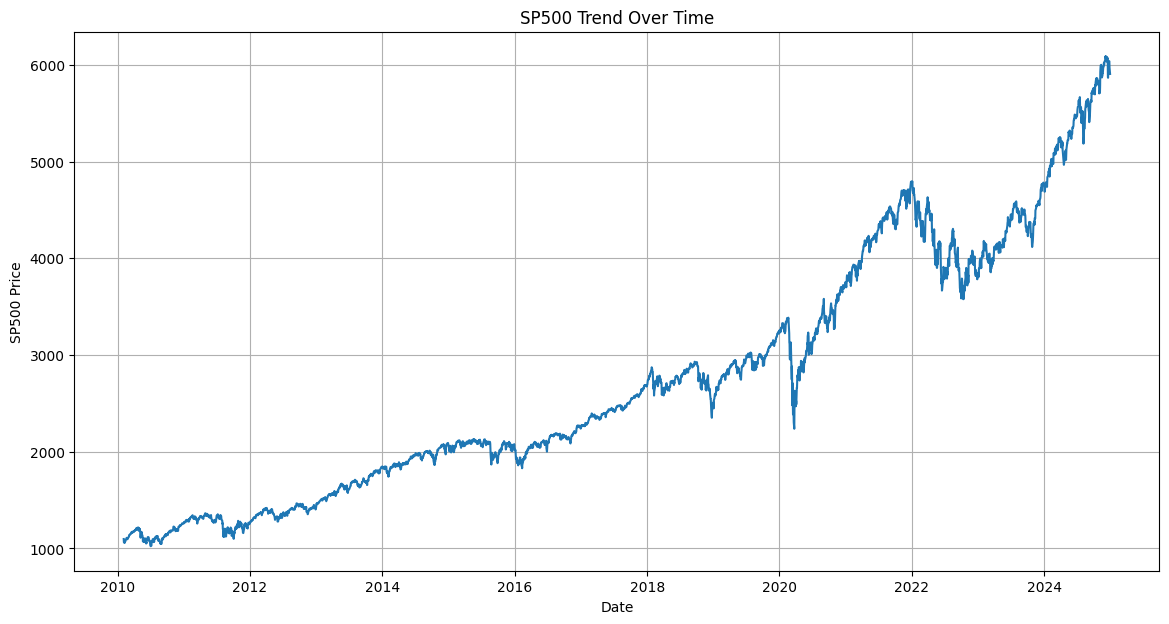

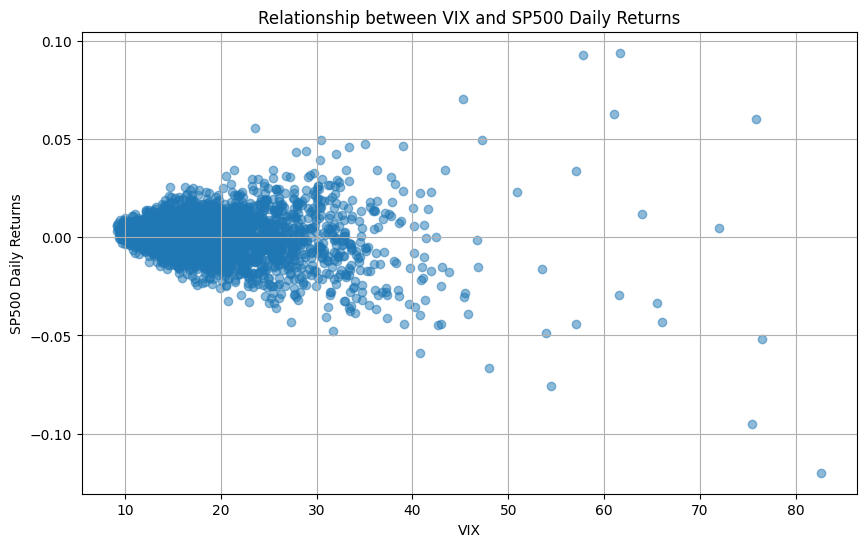

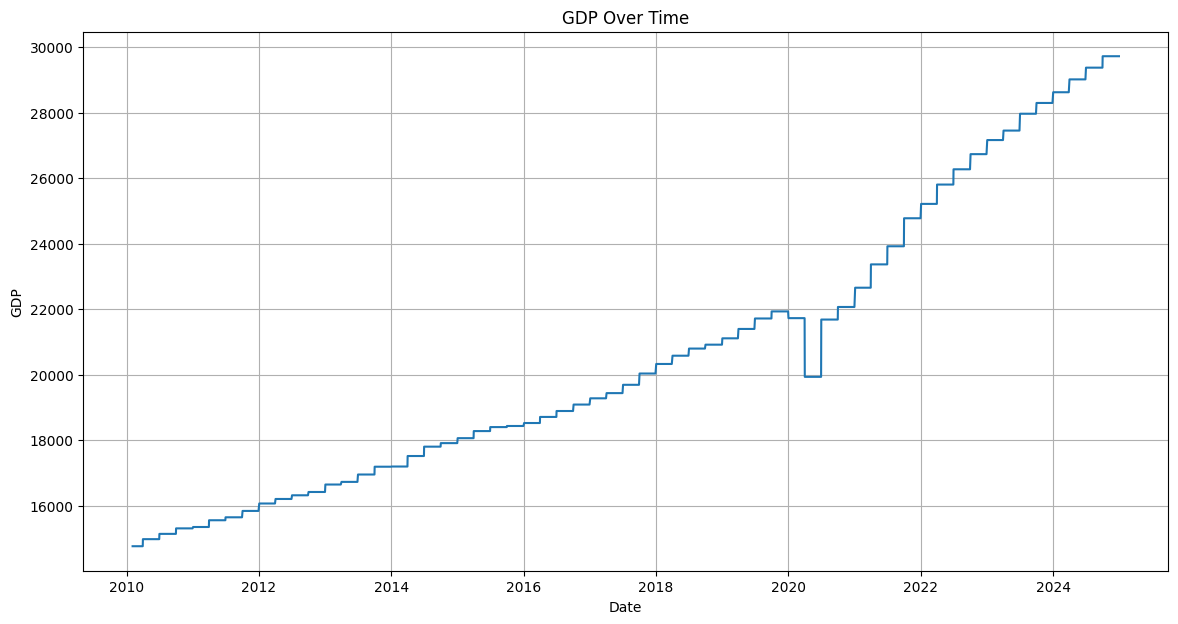

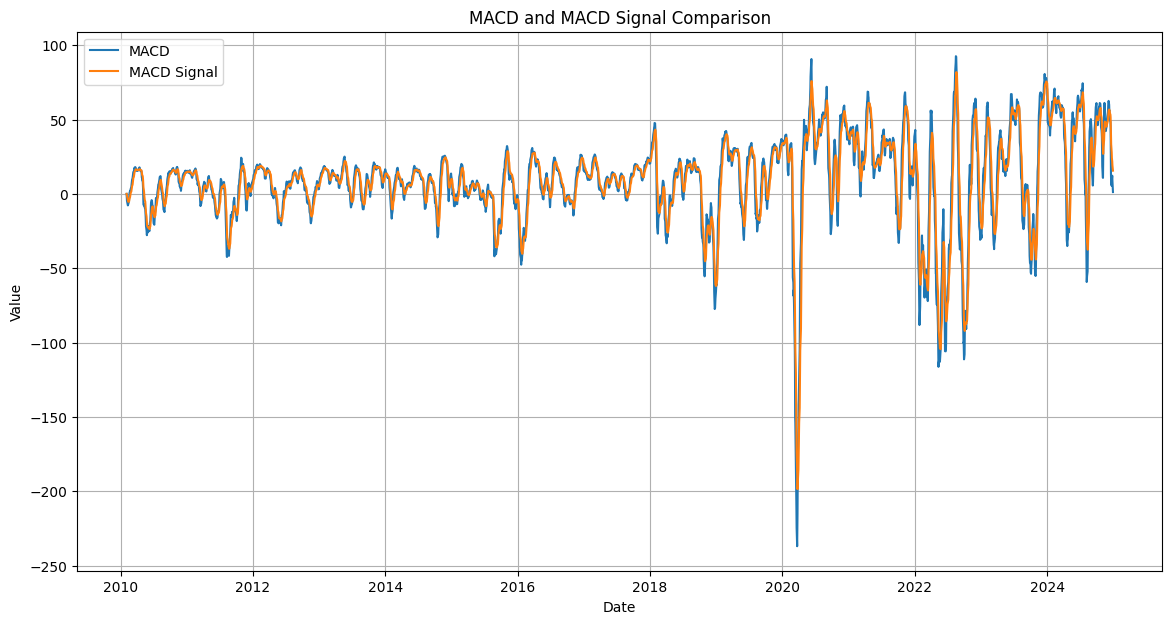

In [ ]:
import matplotlib.pyplot as plt

# Plot the trend of the SP500 over time
plt.figure(figsize=(14, 7))
plt.plot(features['SP500_^GSPC'])
plt.title('SP500 Trend Over Time')
plt.xlabel('Date')
plt.ylabel('SP500 Price')
plt.grid(True)
plt.show()

# Plot the relationship between VIX and SP500 Returns
# Using a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(features['VIX_^VIX'], features['Returns'], alpha=0.5)
plt.title('Relationship between VIX and SP500 Daily Returns')
plt.xlabel('VIX')
plt.ylabel('SP500 Daily Returns')
plt.grid(True)
plt.show()


# Plot how GDP has changed over time
# Using the fred_data_daily dataframe which has daily frequency
plt.figure(figsize=(14, 7))
plt.plot(features_selected_updated['GDP'])
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.grid(True)
plt.show()


# Plot a comparison of MACD and MACD Signal
# Using the features_selected_updated dataframe which contains MACD and MACD_Signal
plt.figure(figsize=(14, 7))
plt.plot(features_selected_updated['MACD'], label='MACD')
plt.plot(features_selected_updated['MACD_Signal'], label='MACD Signal')
plt.title('MACD and MACD Signal Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

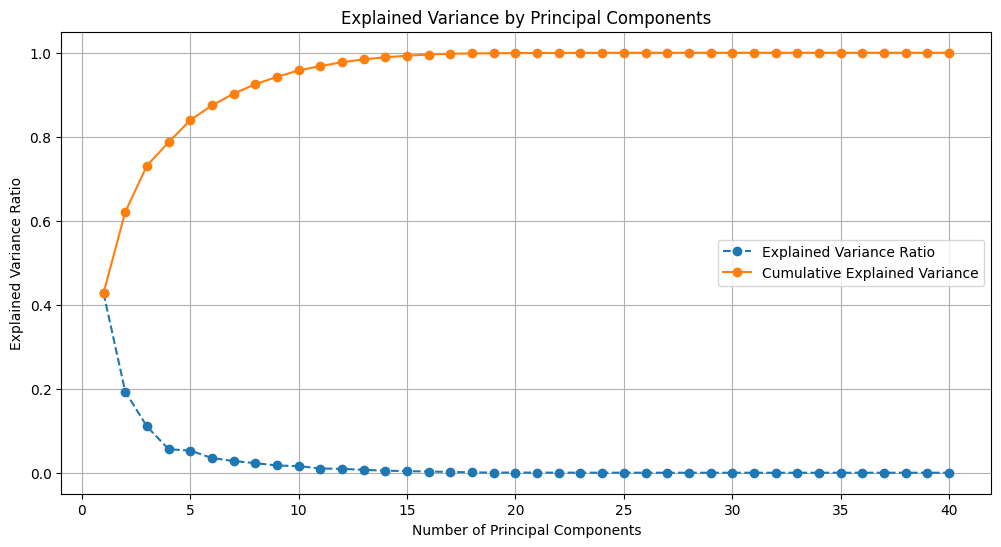


Explained Variance Ratio by Principal Component:
Principal Component 1: 0.4274
Principal Component 2: 0.1933
Principal Component 3: 0.1102
Principal Component 4: 0.0559
Principal Component 5: 0.0527
Principal Component 6: 0.0350
Principal Component 7: 0.0278
Principal Component 8: 0.0228
Principal Component 9: 0.0172
Principal Component 10: 0.0157
Principal Component 11: 0.0100
Principal Component 12: 0.0093
Principal Component 13: 0.0068
Principal Component 14: 0.0049
Principal Component 15: 0.0038
Principal Component 16: 0.0028
Principal Component 17: 0.0019
Principal Component 18: 0.0008
Principal Component 19: 0.0004
Principal Component 20: 0.0004
Principal Component 21: 0.0002
Principal Component 22: 0.0002
Principal Component 23: 0.0001
Principal Component 24: 0.0001
Principal Component 25: 0.0001
Principal Component 26: 0.0000
Principal Component 27: 0.0000
Principal Component 28: 0.0000
Principal Component 29: 0.0000
Principal Component 30: 0.0000
Principal Component 31: 0.000

In [ ]:
# Perform PCA for dimensionality reduction
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Use the cleaned scaled data for PCA
X = scaled_df_updated.copy()

# Ensure X is cleaned of inf and NaN values before fitting
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

pca = PCA()
pca.fit(X)

# Analyze the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio and cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Explained Variance Ratio')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', label='Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Display the explained variance ratio and cumulative explained variance
print("\nExplained Variance Ratio by Principal Component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {ratio:.4f}")

print("\nCumulative Explained Variance:")
for i, cumulative_ratio in enumerate(cumulative_explained_variance):
    print(f"Number of Components {i+1}: {cumulative_ratio:.4f}")

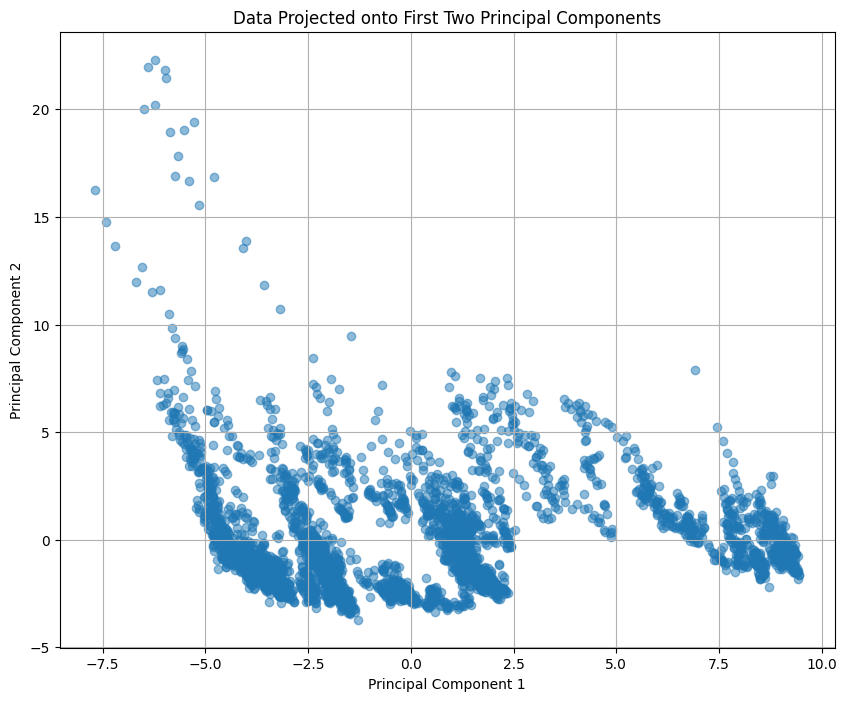

In [ ]:
import matplotlib.pyplot as plt

# Project the data onto the first two principal components
pca_2_components = PCA(n_components=2)
X_pca = pca_2_components.fit_transform(X)

# Create a DataFrame for the PCA results for easier plotting
pca_df = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'], index=X.index)

# Plot the data in the PCA space
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'], alpha=0.5)
plt.title('Data Projected onto First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

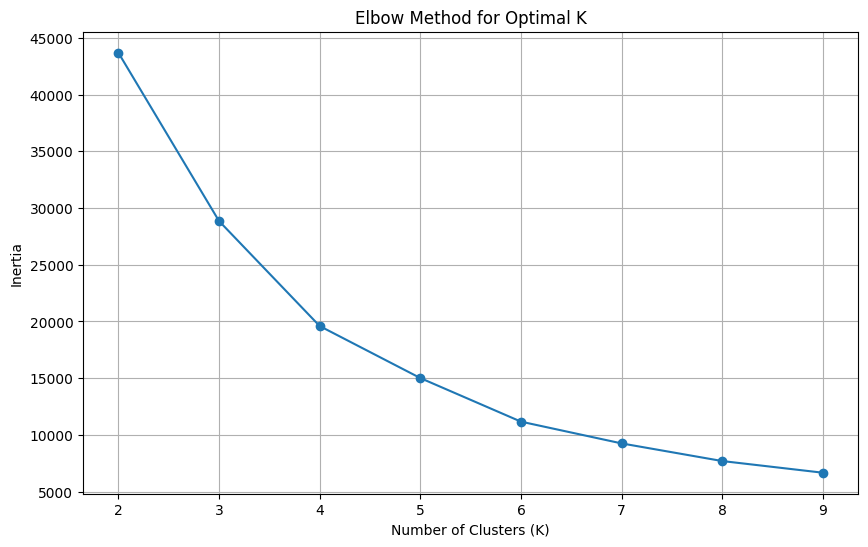

ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

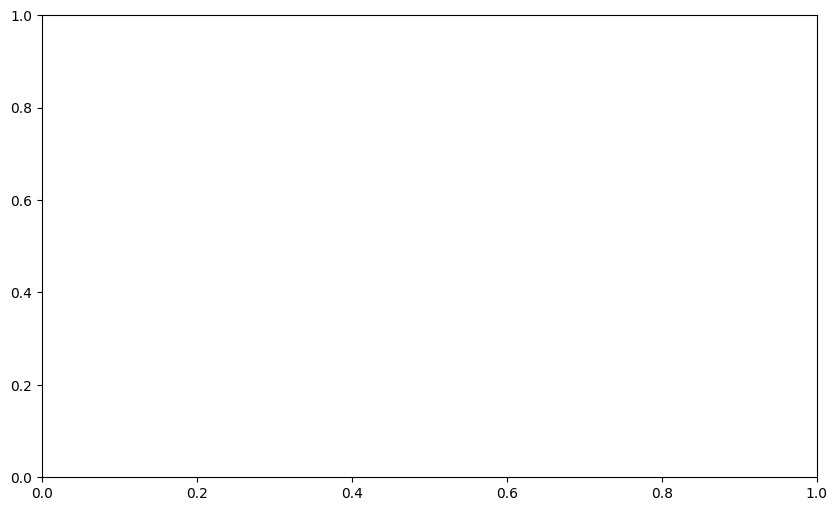

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # Import silhouette_score
import matplotlib.pyplot as plt

# Determine the optimal number of clusters (e.g., using the Elbow method or Silhouette score)
# For demonstration, let's choose a plausible number of clusters based on common market analysis (e.g., 3-5 regimes)
# We can iterate through a range and evaluate
inertia = []
silhouette_scores = []
k_range = range(2, 10) # Testing K from 2 to 9

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init for robustness
    kmeans.fit(X_pca) # Use the PCA transformed data
    inertia.append(kmeans.inertia_)
    # Calculate silhouette score if number of clusters is greater than 1
    if k > 1:
        silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Plot the Silhouette Scores (starting from K=2)
if silhouette_scores:
    plt.figure(figsize=(10, 6))
    plt.plot(k_range[1:], silhouette_scores, marker='o') # k_range[1:] because silhouette scores are calculated for k=2 and above
    plt.title('Silhouette Scores for Different K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_range[1:])
    plt.grid(True)
    plt.show()


# Based on the plots, choose an optimal K (e.g., if the elbow is around 3 or 4)
# Let's assume we choose K=4 for now (you can adjust this based on the plots)
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_pca)

# Add the cluster labels back to the original DataFrame (or the PCA DataFrame)
pca_df['Cluster'] = clusters

# Visualize the clusters on the PCA plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.6)
plt.title(f'PCA with K-Means Clustering (K={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Display the number of data points in each cluster
print(f"\nNumber of data points in each cluster (K={optimal_k}):")
print(pca_df['Cluster'].value_counts())

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_pca, clusters)

# Print the silhouette score
print(f"The average silhouette score is: {silhouette_avg}")